In [66]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from scipy.stats import poisson, lognorm, norm
from random import shuffle

In [67]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

eth_client.get_eth_last_price()

{'ethbtc': '0.06686',
 'ethbtc_timestamp': '1653425791',
 'ethusd': '1969.15',
 'ethusd_timestamp': '1653425791'}

# Nexus Tokenomics Investigation

## Set-up & Parameters

In [68]:
nxm_supply = 6_798_095
act_cover = 190_018
capital_factor = 4.8
mcr_floor = 162_425
cap_pool = 153_397

def mcr():
    return max(mcr_floor, act_cover/capital_factor)

def mcrp(capital):
    return capital/mcr()

def book_value(capital):
    return capital/nxm_supply

print(f'mcrp: {mcrp(cap_pool)}, book value: {book_value(cap_pool)}')

mcrp: 0.9444174234261967, book value: 0.022564703788340704


In [69]:
book_value_usd = book_value(cap_pool)*float(eth_client.get_eth_last_price()['ethusd'])
book_value_usd

44.4332864648111

### Dynamic Current Assets

DCA = Size of capital pool X-days in the future, i.e. current Capital Pool minus everything in the Exit Queue

In [70]:
model_days = 365
bond_length = 14

exit_array = np.zeros((1, model_days*2))
entry_array = np.zeros((1, model_days+bond_length))

In [71]:
cap_pool

153397

In [72]:
# create function that calculates the size of the exit queue
# current book value * notional number of NXM in the exit queue
def exit_queue_size():
    return book_value(cap_pool) * np.sum(exit_array)/30

In [73]:
def dca():
    return cap_pool - exit_queue_size()

In [74]:
dca()

153397.0

### Current & historic wNXM price feed

In [75]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
wnxm_price = requests.get(url, params=params).json()['wrapped-nxm']['eth']
wnxm_price

0.00951326

In [76]:
hist_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm/market_chart'
hist_params = {
        'id':'wrapped-nxm',
        'vs_currency': 'eth',
        'days': 'max'
        }
historic_wnxm_price = requests.get(hist_url, params=hist_params).json()

### Historic wNXM parameters

In [77]:
wNXM_history = pd.DataFrame(historic_wnxm_price['prices'])
wNXM_history.columns = ['block', 'ETH_price']

In [78]:
wNXM_history['change_vs_ETH'] = wNXM_history['ETH_price']/wNXM_history['ETH_price'].shift(1) - 1

In [79]:
wNXM_history[['change_vs_ETH']].describe()

,change_vs_ETH
count,667.000000
mean,0.000154
std,0.065354
min,-0.236422
25%,-0.028496
50%,-0.006860
75%,0.017540
max,0.579456


## Old Model (for reference)

In [80]:
a = 0.01028
c = 5_800_000
token_price = a + (mcr()/c)*(mcrp(cap_pool)**4)
token_price

0.03255823828307842

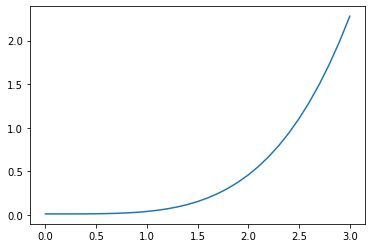

In [81]:
perc_range = np.linspace(0, 3, 31)

token_price_range = a + (mcr()/c)*(perc_range**4)
plt.plot(perc_range, token_price_range);

## New Version - Capital Entry

### Bond Bonus Formula

In [82]:
# creating shape of discount vs. mcr_perc below 100%
def bond_bonus(mcr_perc):
    return 0.2 * (1 - np.exp(-30 * (1-mcr_perc)))

MCR% at 0.0:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.01:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.02:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.03:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.04:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.05:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.06:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.07:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.08:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.09:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.1:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.11:          

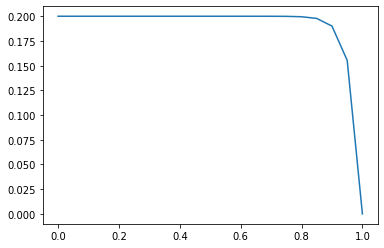

In [83]:
perc_range_below_100 = np.linspace(0, 1, 21)
bond_bonus_range = bond_bonus(perc_range_below_100)
for i in np.linspace(0, 1, 101):
    print(f'MCR% at {round(i, 2)}:\
          Biweekly interest at {round(bond_bonus(i)*100, 2)}%,\
          Annual interest at {round(((1+bond_bonus(i))**26 - 1)*100, 2)}%')
plt.plot(perc_range_below_100, bond_bonus_range);

### Mechanism for Single Entry with Bond

In [84]:
# creates the linear vesting LP token that can be redeemed for NXM as a numpy row vector.
# Will only apply when MCR < 1, otherwise instantaneous exchange of ETH for NXM at wNXM price

# length of simulation
model_days = 365
bond_length = 14
current_day = 0

def single_bond(eth):
    # create array of zeros representing whole modelling period
    row_vec = np.zeros(model_days + bond_length)
    
    # what could someone get now at highest of wnxm price or book value (incl. exit queue)
    nxm_now = eth/max(wnxm_price, book_value(dca()))
    
    # create array of entry-size NXM possibilities over 14 days (and cap at book value)
    nxm_obtained_array = np.linspace(nxm_now, nxm_now*(1+bond_bonus(mcrp(dca()))), bond_length+1)
    nxm_obtained_array[eth/nxm_obtained_array < book_value(dca())] = eth/book_value(dca())
    
    # pick at which point the user will claim their tokens - simplification
    actual_entry_delay = np.random.randint(bond_length + 1)
    
    # replace the relevant time period in question in the array of zeros with the entry NXM obtained
    row_vec[current_day + actual_entry_delay] = nxm_obtained_array[actual_entry_delay]

    return row_vec

In [85]:
nxm_now = 2/max(wnxm_price, book_value(dca()))
nxm_obtained_array = np.linspace(nxm_now, nxm_now*(1+bond_bonus(mcrp(dca()))), bond_length+1)
nxm_obtained_array[2/nxm_obtained_array < book_value(dca())] = 2/book_value(dca())

In [86]:
2/book_value(dca())

88.63400196874777

In [87]:
nxm_obtained_array

array([88.63400197, 88.63400197, 88.63400197, 88.63400197, 88.63400197,
       88.63400197, 88.63400197, 88.63400197, 88.63400197, 88.63400197,
       88.63400197, 88.63400197, 88.63400197, 88.63400197, 88.63400197])

## New Version - Capital Exit

### Weighted average days on covers 

In [ ]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

Treat Weighted Average Days of cover expiry as fixed - unlikely to be able to calculate this on-chain

In [88]:
# bring in csv
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')
# rename columns
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']
# convert expiry time from string to datetime
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])
# create a 'days remaining column by subtracting today's date in datetime format
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()
# create an integer minutes remaining column by dividing by a timedelta minute object
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

#calculate weighted average minutes remaining based on cover amount
wavg_minutes = ((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])
                /active_covers_expiration['ETH'].sum()).sum()

# calculate 
wavg_days = wavg_minutes/(24*60)
wavg_days

55.74942228568537

In [89]:
2*wavg_days

111.49884457137074

### Mechanism for Single Exit

In [90]:
def exit_ratio(days_selected):
    amp_factor = 2
    amp_days = amp_factor * wavg_days
    return min(1, days_selected/amp_days)**2

In [91]:
model_days = 365
current_day = 0
ratio_burned = 0.1

# single_delayed_exit returns a row vector of model_days*2.
# Modelling will likely last a year, so people wishing to exit for a full year at the end of the modelling
# require another year to model into future
# only relevant for mcrp <= 1, otherwise there is an instant exit at book value
def single_delayed_exit(days_selected, exit_period, eth):
    # calculate amount of nxm that user wants to sell from eth they want to obtain
    nxm_now = eth/book_value(dca())
    
    # create empty row vector
    row_vec = np.zeros(model_days*2)
    
    # give user option of exiting over 30 days after their exit ratio period expires
    row_vec[current_day + days_selected:current_day + days_selected + exit_period] = nxm_now * exit_ratio(days_selected)
    return row_vec

### Account for Different Exit Scenarios

## Nexus System Development

Every day, the following happens:

- Users **enter** the system by buying NXM from the mutual **at wNXM price** (or with some discount)
    - expect this number to be higher when mcrp < 1 because there is a discount to wNXM depending on vesting period
    - some will want to buy wNXM for ease, some will want to buy NXM for use on the platform
- Users **exit** from the system **at book value**
    - noone if wNXM price > book value, as first, NXM would be converted to wNXM and sold on the open market. This will drive the price down to book value if more users want to exit.
    - If wNXM price <= book value, expect wNXM buys and exits through book value, driving wNXM price up to book value (with a slight time value discount, assume 5% per year)
- Change in wNXM price
    - if below book value, price gets driven up towards *book value less time discount*
    - if above book value, could go up if mutual doing well, could go down if mutual perceived to be doing badly (e.g. after a big claim)
- Funds come in to capital pool separately through premiums & investment
    - steady stream of income from premiums, possibly increasing, test decrease as well
    - steady stream of income from investments, say 5% on 30% of capital pool to reflect current position
- Funds exit the capital pool through claims
    - rare, but large events
    - possible hits to wNXM price if above book value
- Change in NXM supply
    - entries and exits through capital mechanism (even if NXM created in future)
    - cover buys still create some?
    - some irregular governance rewards
    - burned through cover buys in NXM
    - upon claim, burns of stakers' NXM
- Update active cover amount for tracking mcr requirement
- Update exit queue size
- Update dca & mcrp as a result

In [93]:
# parameters of various developments

nxm_supply = 6_798_095
act_cover = 190_018
capital_factor = 4.8
mcr_floor = 162_425
cap_pool = 153_397
wnxm_price = requests.get(url, params=params).json()['wrapped-nxm']['eth']

# length of simulation
model_days = 365

# ENTERING AND EXITING THE SYSTEM

# assume there are, on average, some same base distribution of entries and exits each day
# modelled by a poisson distribution
lambda_entries = 10
lambda_exits = 10

# lognormal distribution of size of entries & exits in ETH
# parameterised to have  values be small < 1 ETH, the median value to be ~1 ETH,
# upper quartile around 4-5 ETH and the occasional multi-million buy
sale_shape = 2
sale_loc = 0
sale_scale = 1

# assume that everyone selects 130 days to get to maximum exit value
days_selected = 130
# allow a 30 day period for exit option
exit_period = 30
# exit probability each day there is a non-zero value
p_exit = 0.05
# cost of exit option in nxm
option_cost = 0.1

# COVER AMOUNT

# normal distribution of change in cover amount
cover_amount_mean = 0.0075
cover_amount_stdev = 0.07

# PREMIUM INCOME

# lognormal distribution of daily premium income
# parameterised to have median value of a handful of ETH,
# upper quartile around 10 ETH and the occasional multi-million $ day
premium_shape = 2
premium_loc = 0.02
premium_scale = 3

# CLAIM OCCURENCES

# claim frequency
claim_prob = 0.03

# lognormal distribution of claim size
# parameterised to have values of at least 1 ETH, the median value to be ~9 ETH,
# upper quartile around 30 ETH and the occasional multi-million payout
claim_shape = 2
claim_loc = 1
claim_scale = 8

# assume premium was 2.6% of claim size (for assessor NXM rewards)
claim_ass_reward = 0.026 * 0.2

# WNXM PRICE MOVEMENTS

# Random Movement
# normal distribution of change in wnxm price, before any adjustments we assume for what happens
wnxm_drift = 0   # assume there's no long-term drift from ETH
wnxm_diffusion = 0.0655 # st.dev. of historic returns since summer 2020

# Closing to Book Value
# assume that people ascribe a 5% time value to the fixed 130 exit period 
wnxm_discount_to_book = 0.05
# assume that price moves 2% with every 60 ETH
gap_eth_sale = 60
gap_wnxm_move = 0.02

In [94]:
### ---MAIN SIMULATION LOOP--- ###

# set number of base daily entries and exits
daily_entries = poisson.rvs(lambda_entries, size=model_days)
daily_exits = poisson.rvs(lambda_exits, size=model_days)

# start at day 0
current_day = 0

# create empty exit array of ETH liabilities to users and entry array of NXM claims via bonds
exit_array = np.zeros((1, model_days*2))
entry_array = np.zeros((1, model_days+bond_length))

# create tracking for metrics we want to track
mcr_prediction = [mcr()]
cap_pool_prediction = [cap_pool]
mcrp_prediction = [mcrp(dca())]
wnxm_prediction = [wnxm_price]
nxm_supply_prediction = [nxm_supply]
book_value_prediction = [book_value(dca())]
exit_queue_prediction = [exit_queue_size()]
dca_prediction = [dca()]
premium_prediction = [0]
claim_prediction = [0]

In [95]:
# set premium and claims to 0
cum_premiums = 0
cum_claims = 0

for i in range(model_days):
    
    # create list of events that happen today and shuffle them to be random
    events_today = []
    events_today.extend(['entry']*daily_entries[i])
    events_today.extend(['exit']*daily_exits[i])
    events_today.extend(['wnxm_shift'])
    events_today.extend(['premium_income'])
    events_today.extend(['claim_check'])
    events_today.extend(['cover_amount_change'])
    events_today.extend(['bond_entries'])
    events_today.extend(['delayed_exits'])
    shuffle(events_today)
    
    # loop through the day's events
    for event in events_today:
        
        #-----SINGLE ENTRIES-----#
        if event == 'entry':
            # no entries if wnxm price is below book
            if wnxm_price < book_value(dca()):
                continue
            
            # draw entry size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
            # eth enters the capital pool
            cap_pool += eth_size
            
            # NXM Supply changes
            # instantaneous if mcrp >= 1
            if mcrp(dca()) >= 1:
                nxm_supply += eth_size / wnxm_price
                
            # add to queued entry array if mcrp < 1
            else:
                entry_array = np.vstack((entry_array, single_bond(eth_size)))
        
        #-----SINGLE EXITS & GAP CLOSING-----#
        elif event == 'exit':
            # no exits if wnxm price is above book
            if wnxm_price > book_value(dca()):
                continue
            
            # CLOSE WNXM TO BOOK GAP #
            while wnxm_price < book_value(dca())*(1-wnxm_discount_to_book):
                # add eth sale to exit
                exit_array = np.vstack((exit_array,
                        single_delayed_exit(days_selected=days_selected,
                                            exit_period=exit_period,
                                            eth=gap_eth_sale)))
                
                # move wNXM price
                wnxm_price *= 1 + gap_wnxm_move
                # burn 10% of NXM size
                nxm_supply -= gap_eth_sale/book_value(dca()) * option_cost
            
            # SINGLE EXIT #
            # draw exit size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
            # instantaneous exit if mcrp > 1
            if mcrp(dca()) > 1:
                # check whether size reduces mcrp below 1 & turn eth_size into maximum possible
                # such that mcrp doesn't go below 1 
                if mcrp(dca() - eth_size) <= 1:
                    eth_size = dca() - mcr()
                
                # reduce nxm supply and remove ETH from capital pool
                nxm_supply -= eth_size/book_value(dca())
                cap_pool -= eth_size
             
            # add to exit queue if mcrp <= 1
            else:
                exit_array = np.vstack((exit_array,
                                        single_delayed_exit(days_selected=days_selected,
                                                            exit_period=exit_period,
                                                            eth=eth_size)))
                # burn 10% of NXM size
                nxm_supply -= eth_size/book_value(dca()) * option_cost
        
        #-----WNXM RANDOM MARKET MOVEMENT-----#
        elif event == 'wnxm_shift':
            # percentage change according to pre-defined normal distribution
            wnxm_price *= 1 + norm.rvs(loc=wnxm_drift, scale=wnxm_diffusion)
        
        #-----PREMIUM INCOME TO POOL-----#
        elif event == 'premium_income':
            # work out daily premium size in ETH assuming a lognormal distribution
            daily_premiums = lognorm.rvs(s=premium_shape, loc=premium_loc, scale=premium_scale)
            # 50% of premium size gets transformed to NXM and paid out to stakers
            # entry is at wNXM price?
            cap_pool += daily_premiums
            nxm_supply += 0.5 * daily_premiums/wnxm_price
            cum_premiums += daily_premiums
        
        #-----DAILY CHANGE IN COVER AMOUNT-----#
        elif event == 'cover_amount_change':
            # random fluctuation based on normal distribution
            act_cover *= 1 + norm.rvs(loc=cover_amount_mean, scale=cover_amount_stdev)
            
        #-----CLAIM EVENT-----#
        elif event == 'claim_check':
            # check if claims occur
            if np.random.random() > claim_prob:
                continue
            # if a claim has occured, determine size
            claim_size = lognorm.rvs(s=claim_shape, loc=claim_loc, scale=claim_scale)
            # burn 50% of nxm at book value (first!) then remove claims amount from capital pool
            nxm_supply -= 0.5 * claim_size/book_value(dca())
            cap_pool -= claim_size
            cum_claims += claim_size
            # NB: could introduce wNXM shock if claim is over a certain size?
        
        #-----BOND ENTRIES-----#
        elif event == 'bond_entries':
            # sum up entries on current day and add to NXM supply
            nxm_supply += np.sum(entry_array[:, current_day])
        
        #-----DELAYED EXITS-----#
        elif event == 'delayed_exits':
            # don't do this on day zero
            if current_day == 0:
                continue
            
            removal_rows = []
            # slice exit array to current day & loop through entries
            current_exits = exit_array[:, current_day]
            for idx, number_nxm in np.ndenumerate(current_exits):
                # if value is non-zero, check whether user chooses to exit
                if number_nxm != 0:
                    if np.random.random() < p_exit:
                        # successful exit
                        # burn 90% of NXM value that isn't yet burned
                        nxm_supply -= (1-option_cost)*value
                        # remove eth value from capital pool
                        capital_pool -= number_nxm * book_value(dca())
                        # add row to removal_rows
                        removal_rows.append(idx)
                        
                # check whether the option hasn't been exercised & therefore this should be removed
                elif exit_array[idx, current_day-1] != 0:
                    # add row to removal rows
                    removal_rows.append(idx)
                    
                        
            # remove deletable from exit array:
            exit_array = np.delete(exit_array, removal_rows, axis=0)

                    
    mcr_prediction.append(mcr())
    cap_pool_prediction.append(cap_pool)
    exit_queue_prediction.append(exit_queue_size())
    dca_prediction.append(dca())
    book_value_prediction.append(book_value(dca()))
    mcrp_prediction.append(mcrp(dca()))
    wnxm_prediction.append(wnxm_price)
    nxm_supply_prediction.append(nxm_supply)
    premium_prediction.append(cum_premiums)
    claim_prediction.append(cum_claims)

In [96]:
len(mcr_prediction)

366

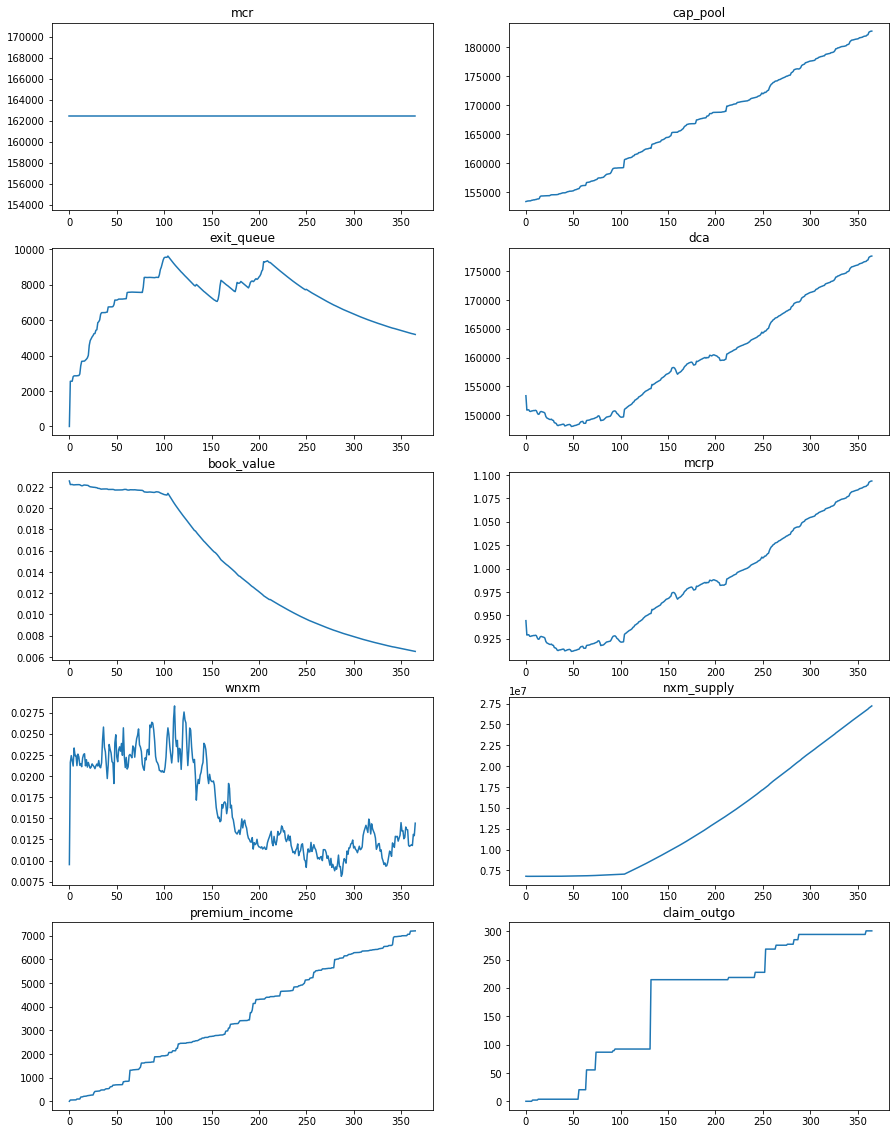

In [97]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(5, 2, figsize=(15,20)) # axs is a (5,2) nd-array

# Subplot 1
axs[0, 0].plot(range(model_days+1), mcr_prediction)
axs[0, 0].set_title('mcr')
# Subplot 2
axs[0, 1].plot(range(model_days+1), cap_pool_prediction)
axs[0, 1].set_title('cap_pool')
# Subplot 3
axs[1, 0].plot(range(model_days+1), exit_queue_prediction)
axs[1, 0].set_title('exit_queue')
# Subplot 4
axs[1, 1].plot(range(model_days+1), dca_prediction)
axs[1, 1].set_title('dca')
# Subplot 5
axs[2, 0].plot(range(model_days+1), book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot 6
axs[2, 1].plot(range(model_days+1), mcrp_prediction)
axs[2, 1].set_title('mcrp')
# Subplot 7
axs[3, 0].plot(range(model_days+1), wnxm_prediction)
axs[3, 0].set_title('wnxm')
# Subplot 8
axs[3, 1].plot(range(model_days+1), nxm_supply_prediction)
axs[3, 1].set_title('nxm_supply')
# Subplot 9
axs[4, 0].plot(range(model_days+1), premium_prediction)
axs[4, 0].set_title('premium_income')
# Subplot 4
axs[4, 1].plot(range(model_days+1), claim_prediction)
axs[4, 1].set_title('claim_outgo');

In [89]:
### TEMPORARY RESET CELL ###

nxm_supply = 6_881_387
act_cover = 176_623
capital_factor = 4.8
mcr_floor = 162_425
cap_pool = 155_772

url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
wnxm_price = requests.get(url, params=params).json()['wrapped-nxm']['eth']

current_day = 0
exit_array = np.zeros((1, model_days*2))
entry_array = np.zeros((1, model_days+bond_length))

## Initial Reverse Dutch Auction Mechanism

At launch, exit price = wnxm price

Price slowly increases, but starts dropping down once people try to exit through the mechanism

Keeps going up, stops at book value.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
What if you believe it'll go up eventually anyway...